***Download the IXI databse which contains IXI-T1 images and we are going to implement them in our training process***

In [ ]:
!wget "http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar"

URL transformed to HTTPS due to an HSTS policy
--2022-06-17 14:22:55--  https://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar
Resolving biomedic.doc.ic.ac.uk (biomedic.doc.ic.ac.uk)... 146.169.22.31
Connecting to biomedic.doc.ic.ac.uk (biomedic.doc.ic.ac.uk)|146.169.22.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4840816640 (4.5G) [application/x-tar]
Saving to: ‘IXI-T1.tar’

IXI-T1.tar          100%[===================>]   4.51G  30.2MB/s    in 2m 36s  

2022-06-17 14:25:32 (29.6 MB/s) - ‘IXI-T1.tar’ saved [4840816640/4840816640]



***Connect the colab to google drive***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Since colab just give you 12 hours perminent access to a gpu we need to save our models and the loads the model and continue the process***

In [ ]:
!unzip '/content/drive/My Drive/pyimagesearch save and load/pyimagesearch.zip'

***we are going to extract 3d mri T1 images to a folder MRI-T1 and we create a folder in the directory***

In [ ]:
!mkdir MRI-T1

In [ ]:
!tar -xvf "/content/IXI-T1.tar" -C "/content/MRI-T1"     #[run this cell to extract tar files]

***As you can check colab gives us a limited memory so after extraction for not to lose the memory we are going to delete the tar folder, please delete the tar zip file from directory***

In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import required libraries
import os
import cv2
import pickle
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from pyimagesearch.callbacks.epochcheckpoint import EpochCheckpoint
from pyimagesearch.callbacks.trainingmonitor import TrainingMonitor
from tensorflow.keras.layers import BatchNormalization
from keras.models import Model,Sequential
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
#from keras.optimizers import Adadelta, RMSprop,SGD
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers
from keras import backend as K
import visualkeras

In [ ]:
#import required libraries
from collections import defaultdict
import numpy as np
import scipy.misc
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib #reading MR images
from sklearn.model_selection import train_test_split
import math
import glob
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
# Reading images from destination folder and sort the files based on names
ff = glob.glob('MRI-T1/*')
x = sorted(ff)

In [ ]:
print(x)

['MRI-T1/IXI002-Guys-0828-T1.nii.gz', 'MRI-T1/IXI012-HH-1211-T1.nii.gz', 'MRI-T1/IXI013-HH-1212-T1.nii.gz', 'MRI-T1/IXI014-HH-1236-T1.nii.gz', 'MRI-T1/IXI015-HH-1258-T1.nii.gz', 'MRI-T1/IXI016-Guys-0697-T1.nii.gz', 'MRI-T1/IXI017-Guys-0698-T1.nii.gz', 'MRI-T1/IXI019-Guys-0702-T1.nii.gz', 'MRI-T1/IXI020-Guys-0700-T1.nii.gz', 'MRI-T1/IXI021-Guys-0703-T1.nii.gz', 'MRI-T1/IXI022-Guys-0701-T1.nii.gz', 'MRI-T1/IXI023-Guys-0699-T1.nii.gz', 'MRI-T1/IXI024-Guys-0705-T1.nii.gz', 'MRI-T1/IXI025-Guys-0852-T1.nii.gz', 'MRI-T1/IXI026-Guys-0696-T1.nii.gz', 'MRI-T1/IXI027-Guys-0710-T1.nii.gz', 'MRI-T1/IXI028-Guys-1038-T1.nii.gz', 'MRI-T1/IXI029-Guys-0829-T1.nii.gz', 'MRI-T1/IXI030-Guys-0708-T1.nii.gz', 'MRI-T1/IXI031-Guys-0797-T1.nii.gz', 'MRI-T1/IXI033-HH-1259-T1.nii.gz', 'MRI-T1/IXI034-HH-1260-T1.nii.gz', 'MRI-T1/IXI035-IOP-0873-T1.nii.gz', 'MRI-T1/IXI036-Guys-0736-T1.nii.gz', 'MRI-T1/IXI037-Guys-0704-T1.nii.gz', 'MRI-T1/IXI038-Guys-0729-T1.nii.gz', 'MRI-T1/IXI039-HH-1261-T1.nii.gz', 'MRI-T1/IXI040-

In [ ]:
# create an empty list
ff2=[]

***For time limitation we can pick up 100 3d mri-T1 image for your own training process you can increase number of 3d-images***

In [ ]:
#select 400 files from mian list
ff2=x[0:100]

In [ ]:
#ff2 contains 400 nii.gz files "3d mri brain images "
len(ff2)

100

In [ ]:
#create an empty list
images = []

***Each 3d MRI-T1 image is a 3d- volume and you can slice it from 3 direction, we pick up a direction which contains more details***

***From each 3d-MRI T1, we cut a 60 slice of a 3d-mri image and append them to list***

***We resize images to 128x128***

In [ ]:
#we pick up 60 slices from each 3d mr image and resize them to 128x128 and add them to images list
for f in range(len(ff2)):
  a=nib.load(ff[f])
  a=a.get_data()
  a = a[120:180,:,:]
  for i in range(a.shape[0]):
    img_2d=a[i,:,:]
    img=cv2.resize(img_2d,(128,128), interpolation = cv2.INTER_AREA)
    images.append(img)
print (a.shape)

In [ ]:
len(images)

6000

In [ ]:
Downsampled_images=[]
up_sampled=[]

***We create 2 list Upsample amd downsamples images and we will downsample the main images which we extracted from 3d-MRI T1 and downsample them and append them to a seprate list and upsamled the downsampled ones and add them to a seprate one as up_sampled list***

In [ ]:
#we have created two empty list. here we downsample images to 64x64 and them upsample them by interpolation
#we add upsampled images to upsampled list and downsample ones to dowsample list
for img in images:
  img_downsample=cv2.resize(img,(64,64),interpolation = cv2.INTER_AREA)
  Downsampled_images.append(img_downsample)
  img_upsample=cv2.resize(img_downsample,(128,128),interpolation = cv2.INTER_AREA)
  up_sampled.append(img_upsample)

In [ ]:
len(up_sampled)

6000

In [ ]:
len(images)

6000

In [ ]:
len(Downsampled_images)

6000

***As you can see here we compare the main images and the images which we upsamped them from the downsampled ones***

(-0.5, 127.5, 127.5, -0.5)

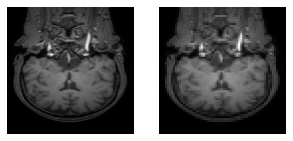

In [ ]:
plt.figure(figsize=[5,5])

# Display the corresponding image in original images
plt.subplot(121)
curr_img = np.reshape(images[185], (128,128))
plt.imshow(curr_img, cmap='gray')
plt.axis('off')

# Display the corresponding image in up_sample list
plt.subplot(122)
curr_img = np.reshape(up_sampled[185], (128,128))
plt.imshow(curr_img, cmap='gray')
plt.axis('off')

In [ ]:
#convert the list to array
images = np.asarray(images)

In [ ]:
Downsampled_images=np.asarray(Downsampled_images)

In [ ]:
up_sampled=np.asarray(up_sampled)

In [ ]:
#check the dimension of images , original with high resolution
images.shape

(6000, 128, 128)

In [ ]:
#check the dimension of images in downsample list , down sampled
Downsampled_images.shape

(6000, 64, 64)

In [ ]:
#check the dimension of images in up_sampled list , have been upsampled from down sampled list
up_sampled.shape

(6000, 128, 128)

***For preserve the memory we delete the MRI_T1 folder***

We change the dimension of array , to be appropiriate to network

In [ ]:
import shutil
shutil.rmtree('/content/MRI-T1')

In [ ]:
images = images.reshape(-1, 128,128,1)

In [ ]:
up_sampled = up_sampled.reshape(-1, 128,128,1)

In [ ]:
Downsampled_images=Downsampled_images.reshape(-1,128,128,1)

In [ ]:
images.shape

(6000, 128, 128, 1)

In [ ]:
up_sampled.shape

(6000, 128, 128, 1)

In [ ]:
Downsampled_images.shape

(1500, 128, 128, 1)

We normalized the images inside the list

In [ ]:
m = np.max(images)
mi = np.min(images)

In [ ]:
images = (images - mi) / (m - mi)

In [ ]:
m = np.max(Downsampled_images)
mi = np.min(Downsampled_images)

In [ ]:
Downsampled_images = (Downsampled_images- mi) / (m - mi)

In [ ]:
m = np.max(up_sampled)
mi = np.min(up_sampled)

In [ ]:
up_sampled=(up_sampled-mi)/(m-mi)

***We use the main images and up-sampled ones***

***We remove the random state, since we want to have ground truth image and up_scaled one from the up_sampled in correspondence***

In [ ]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(up_sampled
                                                             ,images,
                                                             test_size=0.2)

***For confidency of correspodency in training and test data , we visualize an image from gournd truth taining , test and up_samples from taining and test respectively***

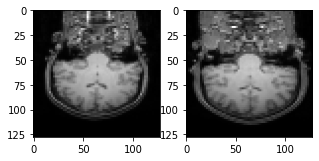

In [ ]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_X[102], (128,128))
plt.imshow(curr_img, cmap='gray')
plt.grid(False)

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(valid_X[102], (128,128))
plt.imshow(curr_img, cmap='gray')

plt.grid(False)

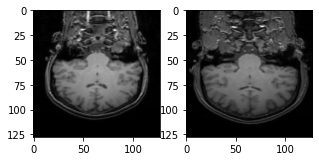

In [ ]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_ground[102], (128,128))
plt.imshow(curr_img, cmap='gray')
plt.grid(False)

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(valid_ground[102], (128,128))
plt.imshow(curr_img, cmap='gray')

plt.grid(False)

In [ ]:
batch_size = 128
epochs = 3000
inChannel = 1
x, y = 128, 128
input_img = Input(shape = (x, y, inChannel))

In [ ]:
# build the path to the training plot and training history
plotPath = os.path.sep.join(["/content/drive/My Drive", "mri_reconstruction_plot.png"])
jsonPath = os.path.sep.join(["/content/drive/My Drive", "mri_reconstruction_plot.json"])
# construct the set of callbacks
# construct the set of callbacks
callbacks = [
EpochCheckpoint("/content/drive/My Drive", every=3000, startAt=0),
TrainingMonitor(plotPath,jsonPath,0)]

In [ ]:
def autoencoder(input_img):
    #encoder

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)


    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

In [ ]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer ='adam',metrics=["accuracy"])

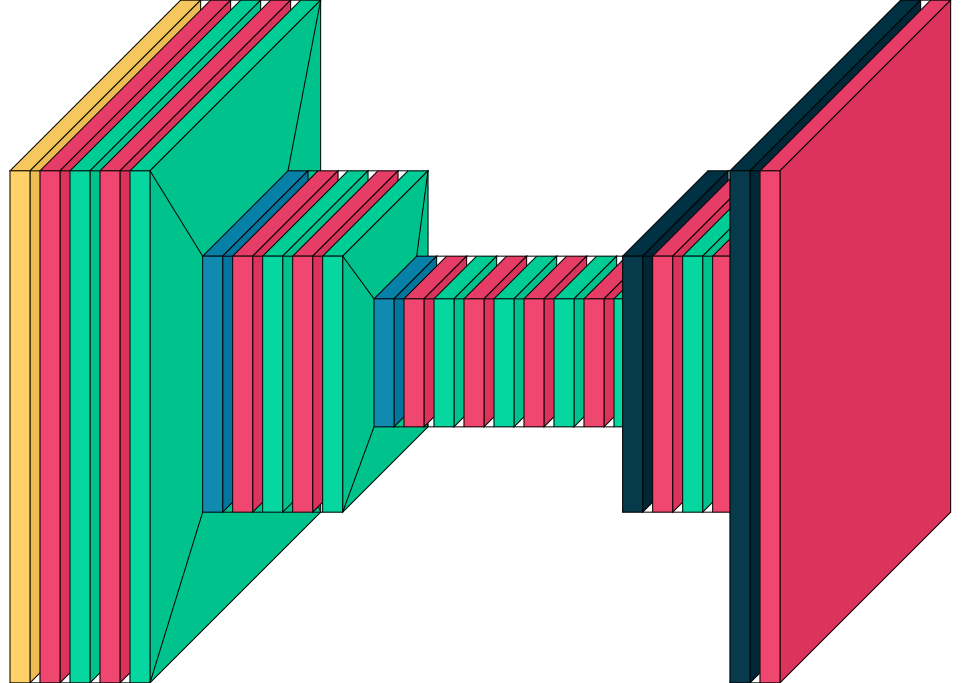

In [ ]:
visualkeras.layered_view(autoencoder)
visualkeras.layered_view(autoencoder, to_file='output.png')

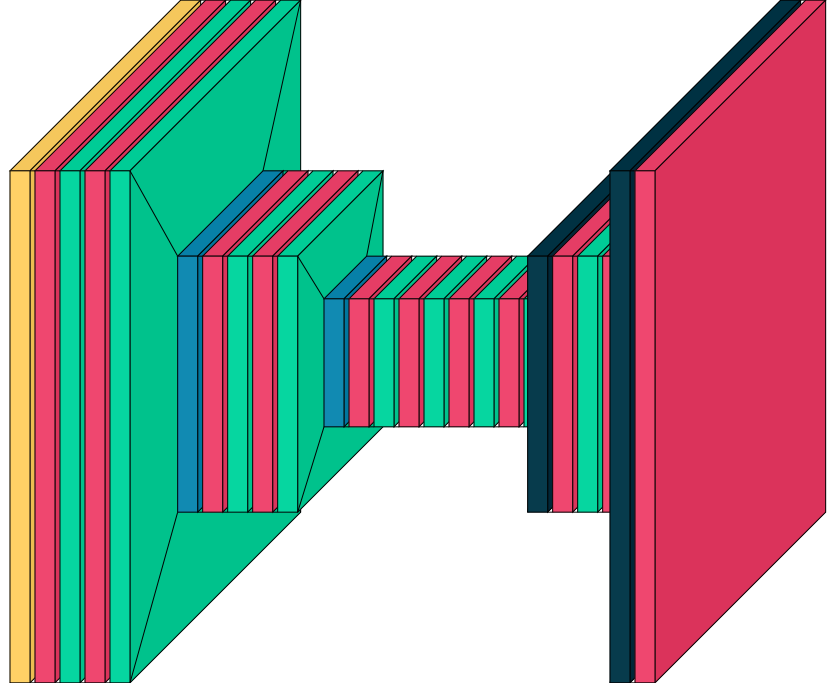

In [ ]:

visualkeras.layered_view(autoencoder,spacing=5)

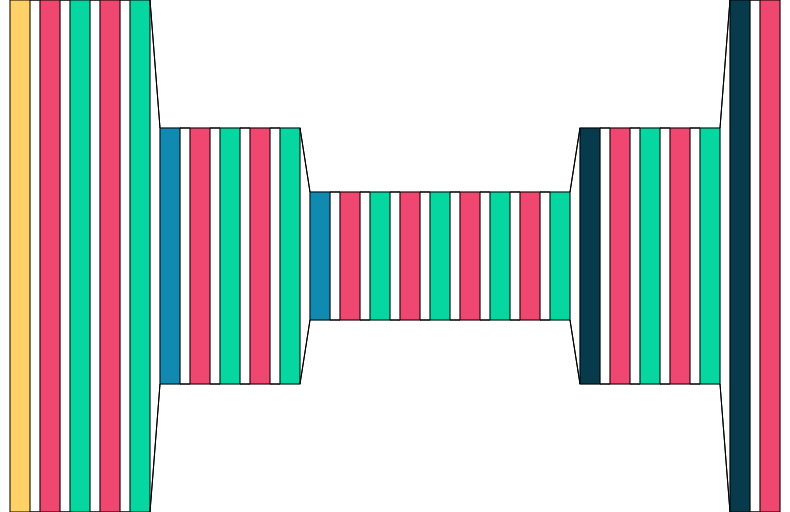

In [ ]:
visualkeras.layered_view(autoencoder, draw_volume=False)

In [ ]:
visualkeras.SpacingDummyLayer(spacing=0)

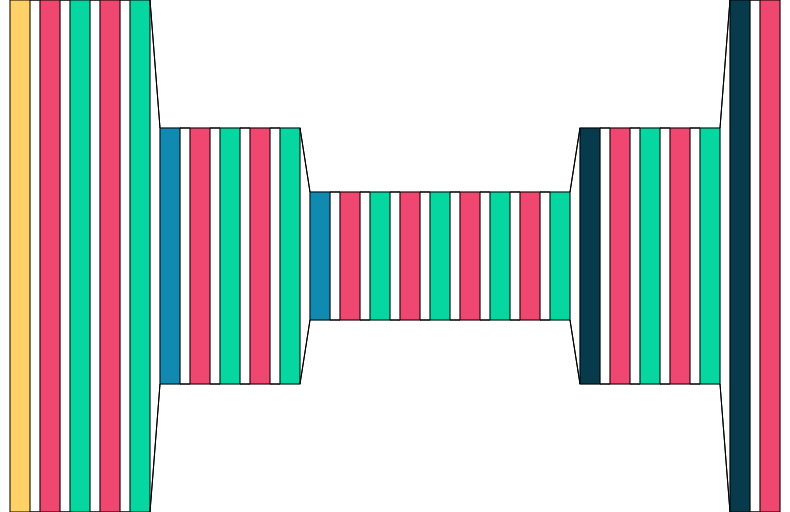

In [ ]:
visualkeras.layered_view(autoencoder, draw_volume=False)

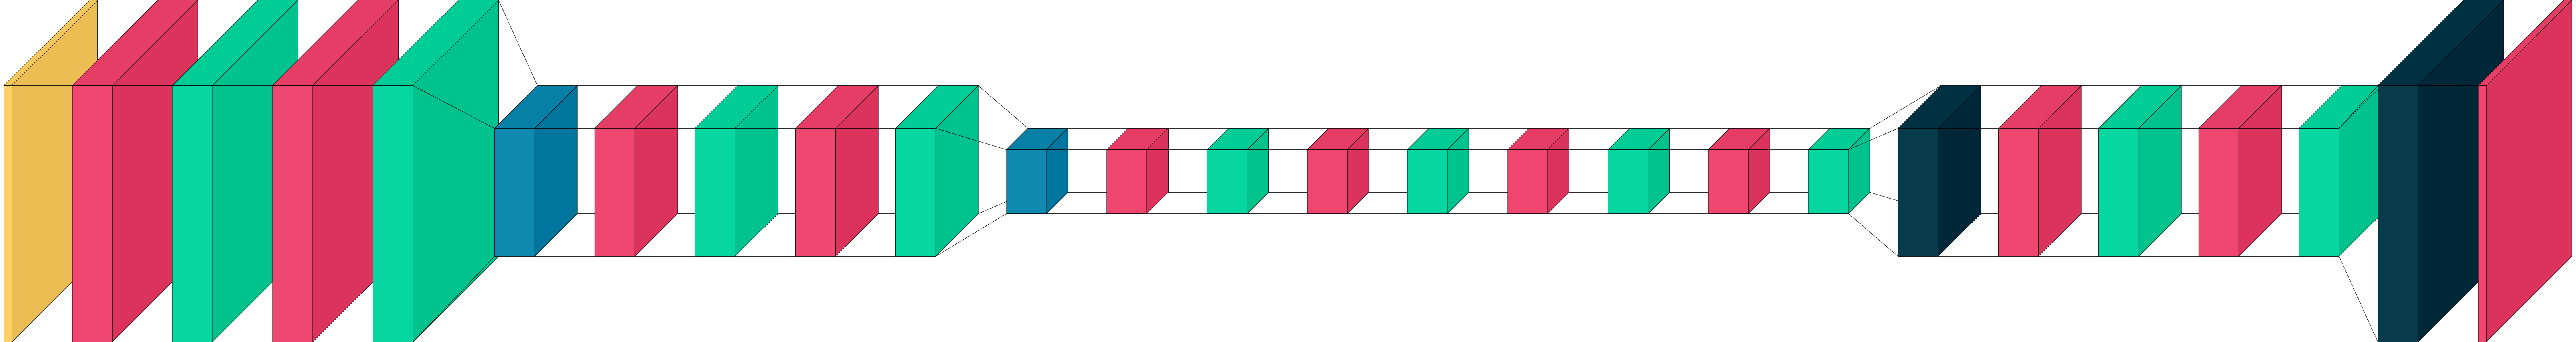

In [ ]:
visualkeras.layered_view(autoencoder, scale_xy=5, scale_z=10, max_z=100,to_file='output.png',spacing=150)


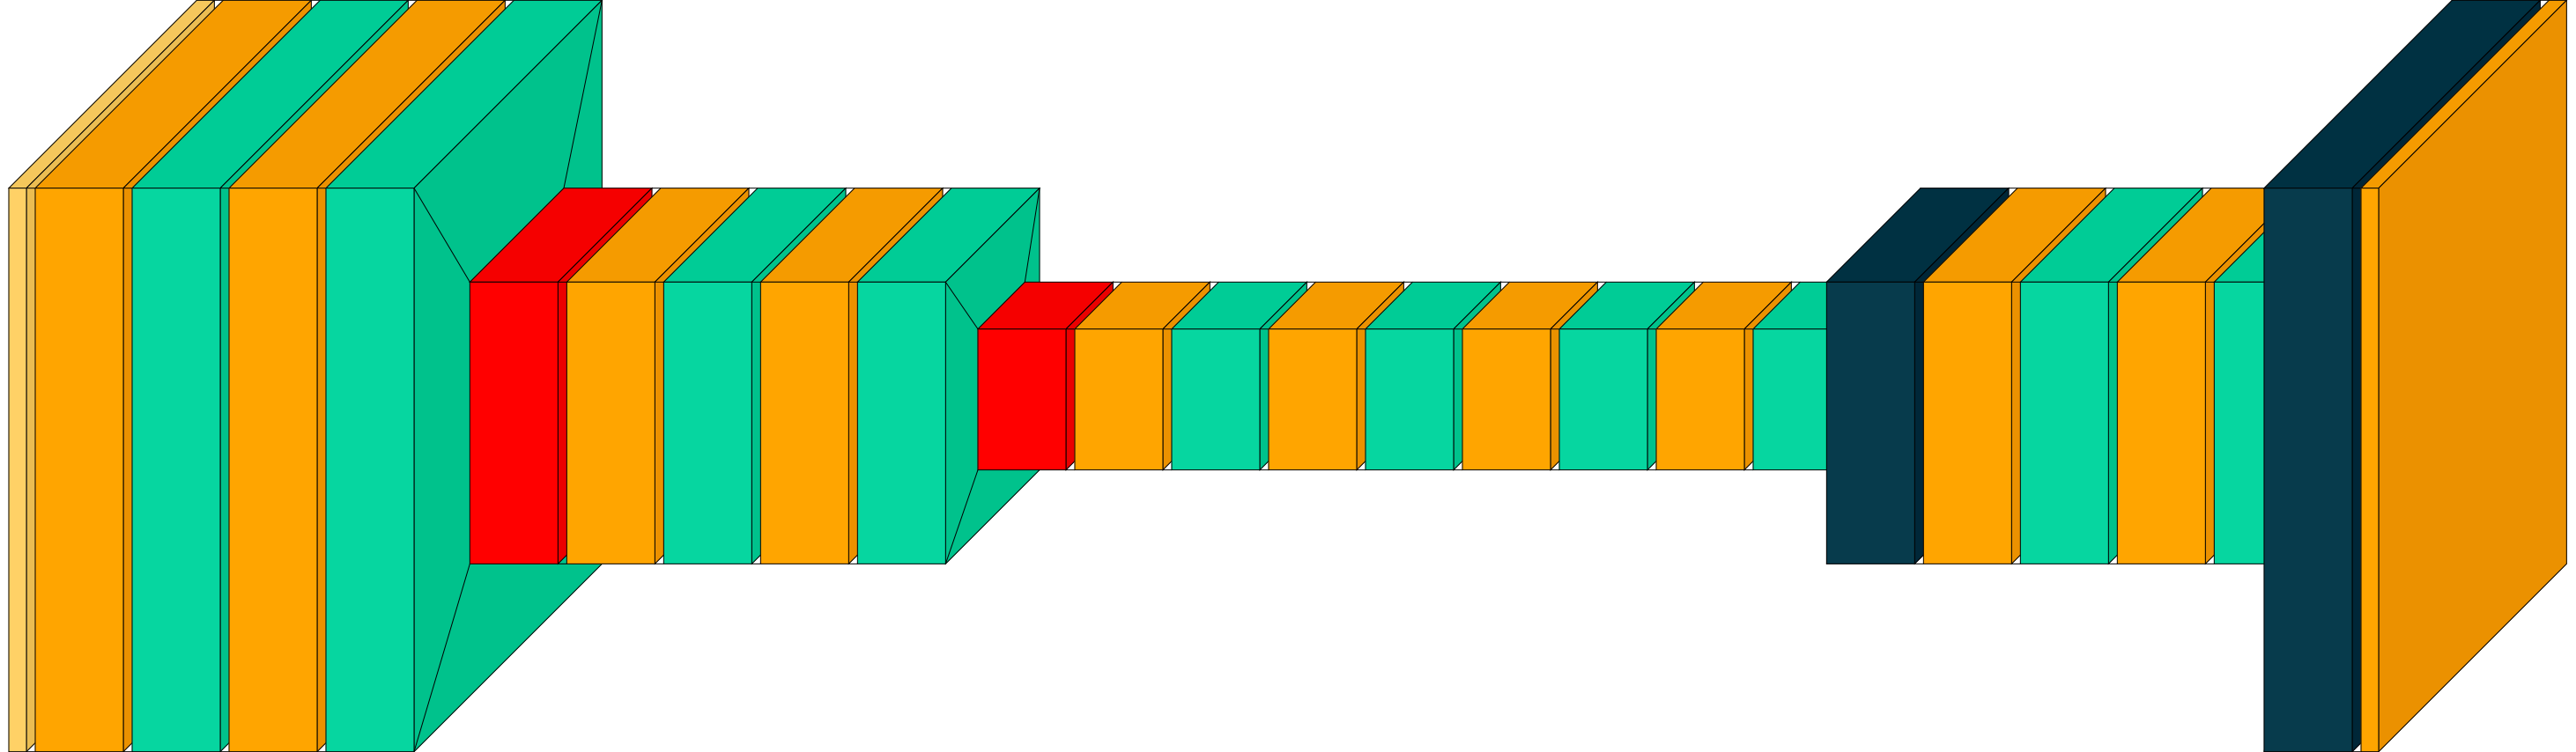

In [ ]:
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
#color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

visualkeras.layered_view(autoencoder, color_map=color_map,scale_xy=5, scale_z=10, max_z=100,to_file='output.png')

In [ ]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 batch_normalization_10 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_11 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0   

In [ ]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground),callbacks=callbacks)

In [ ]:
model = load_model('/content/drive/My Drive/Image Up-Sampling Autoencoder Saved model/epoch_90.hdf5')

In [ ]:
pred = model.predict(valid_X)

Low Resolution Images Input to the Network (a)


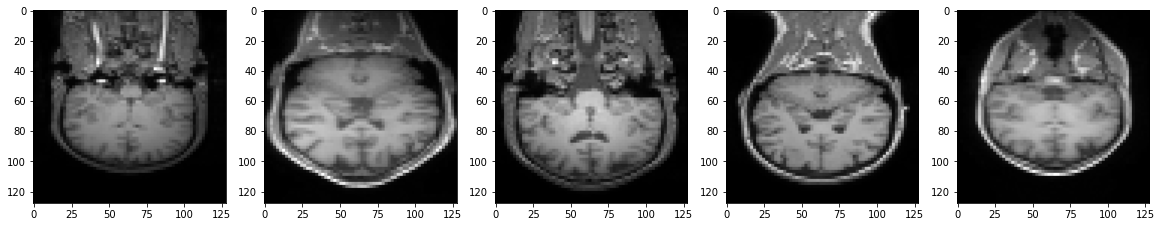

Super Resoltuion Images Generated by Model Based on Auto-Encoder (b) 


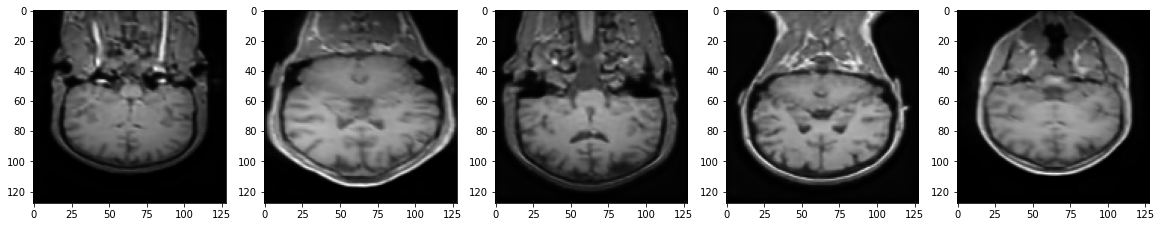

the original images from which low-resolution images are made (c)


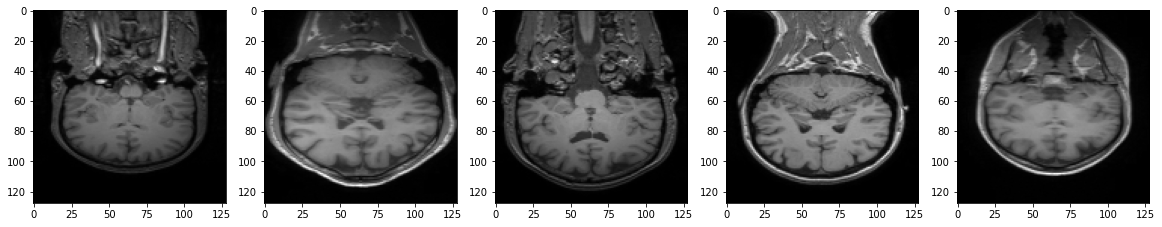

In [ ]:
# plt.figure(figsize=(20, 4))
# print("Input")
# for i in range(5):
#     plt.subplot(1, 5, i+1)
#     plt.imshow(Downsampled_images[i, ..., 0], cmap='gray')
#     plt.grid(False)
# plt.show()



plt.figure(figsize=(20, 4))
print("Low Resolution Images Input to the Network (a)")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(valid_X[i, ..., 0], cmap='gray')
    plt.grid(False)
plt.show()


plt.figure(figsize=(20, 4))
print("Super Resoltuion Images Generated by Model Based on Auto-Encoder (b) ")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')
    plt.grid(False)
plt.show()

plt.figure(figsize=(20, 4))
print("the original images from which low-resolution images are made (c)")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(valid_ground[i, ..., 0], cmap='gray')
    plt.grid(False)
plt.show()

In [ ]:
valid_pred = model.predict(valid_X)
mse =  np.mean((valid_X - valid_pred) ** 2)
psnr = 20 * math.log10( 1.0 / math.sqrt(mse))

In [ ]:
print('PSNR of reconstructed validation images: {psnr}dB'.format(psnr=np.round(psnr,2)))

PSNR of reconstructed validation images: 35.63dB
